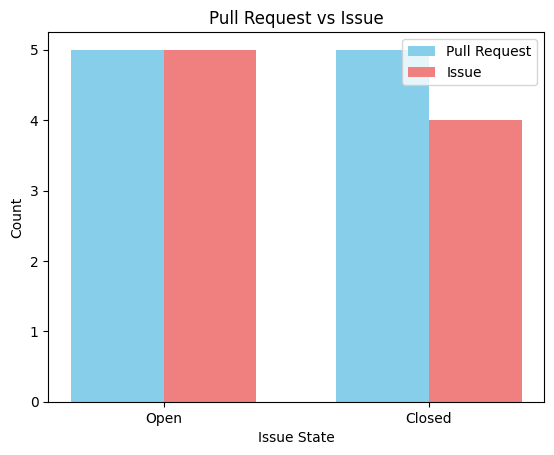

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime


def load_json(json_file_path):
    """Load JSON data from a file."""
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def preprocess_and_clean(json_data):

    # Define a function to clean text
    def clean_text(text):
        if text is not None:
            # Remove Unicode escape sequences
            cleaned_text = text.encode('utf-8').decode('unicode-escape')
            # Remove emoji symbols
            cleaned_text = cleaned_text.encode('ascii', 'ignore').decode('ascii')
            # Remove extra whitespaces
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
            return cleaned_text
        return None

    # Define a function to convert date strings to datetime objects
    def convert_to_datetime(date_str):
        if date_str is not None:
            return datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
        return None

    # Clean and handle null values for top-level attributes
    json_data['CreatedAt'] = convert_to_datetime(json_data.get('CreatedAt'))
    json_data['ClosedAt'] = convert_to_datetime(json_data.get('ClosedAt'))
    json_data['MergedAt'] = convert_to_datetime(json_data.get('MergedAt'))
    json_data['UpdatedAt'] = convert_to_datetime(json_data.get('UpdatedAt'))
    json_data['Title'] = clean_text(json_data.get('Title'))
    json_data['Body'] = clean_text(json_data.get('Body'))

    # Clean and handle null values for nested conversation data
    if 'ChatgptSharing' in json_data:
        for convo in json_data['ChatgptSharing']:
            convo['URL'] = clean_text(convo.get('URL'))
            convo['Title'] = clean_text(convo.get('Title'))
            convo['DateOfConversation'] = convert_to_datetime(convo.get('DateOfConversation'))

            if 'Conversations' in convo:
                convo['Conversations'] = [
                    {
                        'Prompt': clean_text(c.get('Prompt')),
                        'Answer': clean_text(c.get('Answer')),
                        'ListOfCode': c.get('ListOfCode') if 'ListOfCode' in c else None
                    }
                    for c in convo['Conversations']
                ]

    return json_data


def extract_prompt_counts(source, state):
    """Extract the prompt counts from the given source and state."""
    prompts = []
    for entry in source['ChatgptSharing']:
        if 'NumberOfPrompts' in entry and entry['NumberOfPrompts'] is not None:
            prompts.append(entry['NumberOfPrompts'])
    return prompts

def calculate_average(prompt_list):
    """Calculate the average of a list of prompt counts."""
    if not prompt_list:
        return 0
    return round(sum(prompt_list) / len(prompt_list))

def plot_side_by_side_bar_chart(categories, values_pr, values_issue, chart_title):
    """Plot side-by-side bar charts with interactive colors."""
    bar_width = 0.35  # Define the width of the bars

    fig, ax = plt.subplots()

    pr_bars = ax.bar(np.arange(len(categories)) - bar_width/2, values_pr, bar_width, label='Pull Request', color='skyblue')
    issue_bars = ax.bar(np.arange(len(categories)) + bar_width/2, values_issue, bar_width, label='Issue', color='lightcoral')

    # Adding labels and title
    ax.set_xlabel('Issue State')
    ax.set_ylabel('Count')
    ax.set_title(chart_title)
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the bar chart
    plt.show()

def AvgPromptCount(json_file_path_pr, json_file_path_issue, chart_title):
    """Calculate and plot the average prompt counts for open and closed states."""

    data_pr = load_json(json_file_path_pr)
    cleaned_data_pr = preprocess_and_clean(data_pr)

    data_issue = load_json(json_file_path_issue)
    cleaned_data_issue = preprocess_and_clean(data_issue)

    opened_pr, closed_pr = [], []
    opened_issue, closed_issue = [], []

    for source in cleaned_data_pr['Sources']:
        if source['State'] == "CLOSED":
            closed_pr.extend(extract_prompt_counts(source, 'CLOSED'))
        else:
            opened_pr.extend(extract_prompt_counts(source, 'OPEN'))

    avg_opened_pr = calculate_average(opened_pr)
    avg_closed_pr = calculate_average(closed_pr)

    for source in cleaned_data_issue['Sources']:
        if source['State'] == "CLOSED":
            closed_issue.extend(extract_prompt_counts(source, 'CLOSED'))
        else:
            opened_issue.extend(extract_prompt_counts(source, 'OPEN'))

    avg_opened_issue = calculate_average(opened_issue)
    avg_closed_issue = calculate_average(closed_issue)

    categories = ['Open', 'Closed']

    plot_side_by_side_bar_chart(categories, [avg_opened_pr, avg_closed_pr], [avg_opened_issue, avg_closed_issue], chart_title)


json_file_path_pr = 'Snapshots/20230831_060603_pr_sharings.json'
json_file_path_issue = 'Snapshots/20230831_061759_issue_sharings.json'

AvgPromptCount(json_file_path_pr, json_file_path_issue, 'Pull Request vs Issue')